In [1]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# --- Grid Parameters ---
NX, NY = 200, 400
XMIN, XMAX = 0.0, 2000.0
YMIN, YMAX = 0.0, 4000.0
DX = (XMAX - XMIN) / NX
DY = (YMAX - YMIN) / NY
DT = 0.001
t_max = 4.0
time = np.arange(0, t_max, DT)
NT = len(time)

# Animation config
PLOT_EVERY = 5  # Plot every 5 time steps
frames = len(time) // PLOT_EVERY

# --- Velocity Model ---
VEL_P = np.zeros((NX, NY))
VEL_S = np.zeros((NX, NY))

In [3]:
# Define material layers: (start_y, end_y, Vp, Vs)
# Use 0 for Vs in air/water instead of NaN values
layers = [
    (0, 60, 1200, 500),        # dry sands
    (60, 120, 3800, 1900),     # ice
    (120, 180, 1700, 500),    # Wet Sands
    (180, 250, 2800, 1200),   # Sandstone
    (250, 320, 4500, 2500),   # Limestone
    (320, 400, 5500, 3000),   # Granite
]

for y_start, y_end, vp, vs in layers:
    VEL_P[:, y_start:y_end] = vp
    VEL_S[:, y_start:y_end] = vs

RHO = np.ones((NX, NY)) * 2200.0

In [4]:
# Seismogram Profiles
source_x = NX // 2
vp_profile = VEL_P[source_x, :]
vs_profile = VEL_S[source_x, :]
rho_profile = RHO[source_x, :]

### Reflection Coefficient
Reflection coefficient is a measure of how much of a wave reflection when it encounters a change in medium, such as between sands and stone. As we can see before, each medium has different P-wave velocity and S-wave velocity, which causes this wave reflection.

$$
    R = {(Z_2 - Z_1)/(Z_2 + Z_1)}
$$
where
- $Z$ is the impedance which can be calculated using ${\rho . v}$

We will calculate the R coefficient separately for each wave.


In [5]:
def compute_reflection_coeffs(vel_profile, rho_profile):
    rc = []
    for i in range(len(vel_profile) - 1):
        # Skip if either current or next layer has Vs=0 (air/water)
        if vel_profile[i] == 0 or vel_profile[i+1] == 0:
            rc.append(0)  # No reflection
            continue
            
        z1 = rho_profile[i] * vel_profile[i]
        z2 = rho_profile[i+1] * vel_profile[i+1]
        r = (z2 - z1) / (z2 + z1)
        rc.append(r)
    return np.array(rc)

rc_p = compute_reflection_coeffs(vp_profile, rho_profile)
rc_s = compute_reflection_coeffs(vs_profile, rho_profile)

### Two-Way Travel Time (TWT)

TWT is the total time needed for a seismic wave to travel from the reflector to the receiver.

$$
    TWT = {2 . (d_i/v_i)}
$$
where
- $d_i$ is the thickness of layer i
- $v_i$ is the wave velocity in layer i

In [6]:
def compute_twt(vel_profile, dy):
    twt = [0.0]
    for i in range(1, len(vel_profile)):
        if vel_profile[i] == 0:  # Skip S-wave in air/water
            twt.append(np.inf)   # Infinite travel time (never arrives)
            continue
        avg_v = (vel_profile[i-1] + vel_profile[i]) / 2
        dt_depth = 2 * dy / avg_v
        twt.append(twt[-1] + dt_depth)
    return np.array(twt)

twt_p = compute_twt(vp_profile, DX)
twt_s = compute_twt(vs_profile, DX)

### Reflectivity Series

Reflectivity series is a sequence of values that represents the reflection in different depth or locations. Each spike in the series symbolizes a reflection with its amplitude corresponds to Reflection Coefficient (R).

In [7]:
def create_reflectivity_series(rc, twt, time, dt):
    series = np.zeros_like(time)
    for i, t in enumerate(twt[:-1]):
        if np.isinf(t):  # Skip if travel time is infinite
            continue
        idx = int(t / dt)
        if 0 <= idx < len(series):
            series[idx] = rc[i]
    return series

reflectivity_p = create_reflectivity_series(rc_p, twt_p, time, DT)
reflectivity_s = create_reflectivity_series(rc_s, twt_s, time, DT)

In [8]:
# --- Ricker Wavelet ---    
# Used to simulate the source wavelet
def ricker_wavelet(t, f0=20.0):
    return (1.0 - 2.0*(np.pi*f0*t)**2) * np.exp(-(np.pi*f0*t)**2)

f0_p = 20.0
f0_s = 15.0
t_wavelet = np.linspace(-0.1, 0.1, int(0.2 / DT))
wavelet_p = ricker_wavelet(t_wavelet, f0_p)
wavelet_s = ricker_wavelet(t_wavelet, f0_s)

### Convolution 

Convolution is a mathematical operation to combine two functions and see the overlapped part. We will convolute the wavelet and reflectivity series to produce the seismogram.

$$
Seismogram = {wavelet * reflectivity\space series}
$$

In [9]:
# --- Create Seismograms ---
seismogram_p = np.convolve(reflectivity_p, wavelet_p, mode='same')
seismogram_s = np.convolve(reflectivity_s, wavelet_s, mode='same')
seismogram_s *= 1.5  # Amplify S-wave
seismogram_s = np.roll(seismogram_s, int(0.2 / DT))  # Phase shift

combined_seismogram = seismogram_p + seismogram_s

In [10]:
# --- Animation for seismogram with combined P and S wave ---
# fig, ax = plt.subplots(figsize=(10, 4))
# line, = ax.plot([], [], color='purple', label='Combined Seismogram')
# ax.set_xlim(0, time[-1])
# ax.set_ylim(np.min(combined_seismogram) * 1.1, np.max(combined_seismogram) * 1.1)
# ax.set_xlabel('Time (s)')
# ax.set_ylabel('Amplitude')
# ax.set_title('Seismogram Animation (P + S)')
# ax.grid(True)
# ax.legend()

# def init():
#     line.set_data([], [])
#     return line,

# def update(frame):
#     idx = min(frame * PLOT_EVERY, len(time) - 1)  # Ensure we don't exceed array bounds
#     line.set_data(time[:idx], combined_seismogram[:idx])
#     return line,

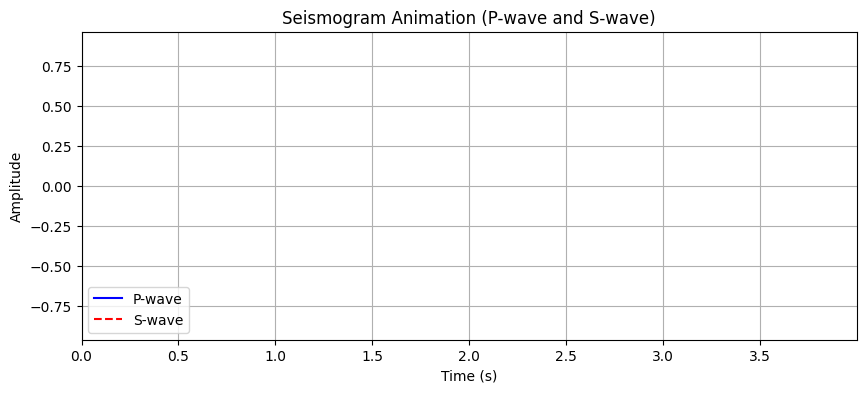

In [11]:
# --- Animation for seismogram with separated P and S wave ---
fig, ax = plt.subplots(figsize=(10, 4))
line_p, = ax.plot([], [], color='blue', label='P-wave')
line_s, = ax.plot([], [], color='red', label='S-wave', linestyle='--')

ax.set_xlim(0, time[-1])
min_val = min(seismogram_p.min(), seismogram_s.min()) * 1.1
max_val = max(seismogram_p.max(), seismogram_s.max()) * 1.1
ax.set_ylim(min_val, max_val)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude')
ax.set_title('Seismogram Animation (P-wave and S-wave)')
ax.grid(True)
ax.legend(loc='lower left')

def init():
    line_p.set_data([], [])
    line_s.set_data([], [])
    return line_p, line_s

def update(frame):
    idx = min(frame * PLOT_EVERY, len(time) - 1)
    line_p.set_data(time[:idx], seismogram_p[:idx])
    line_s.set_data(time[:idx], seismogram_s[:idx])
    return line_p, line_s

In [12]:
ani = FuncAnimation(fig, update, frames=frames, init_func=init, interval=20, blit=True)
ffmpeg_writer = animation.FFMpegWriter(fps=20)
ani.save('separated_seismogram.mp4', writer=ffmpeg_writer)